In [1]:
# to read and wrangle data
import pandas as pd

# to import data from LA Data portal
from sodapy import Socrata

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px
# import k-means from clustering stage

import sklearn
from sklearn.cluster import KMeans

!pip install folium # map rendering library
import folium

from sklearn.preprocessing import StandardScaler

print('Libraries imported.')

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


Libraries imported.


In [2]:
# to illustrate, bring in tracts
gdf_tracts = gpd.read_file('data/tracts.geojson')

In [3]:
# population block group data from census reporter
gdf = gpd.read_file('data/acs2018_5yr_B01003_15000US060372711003.geojson')

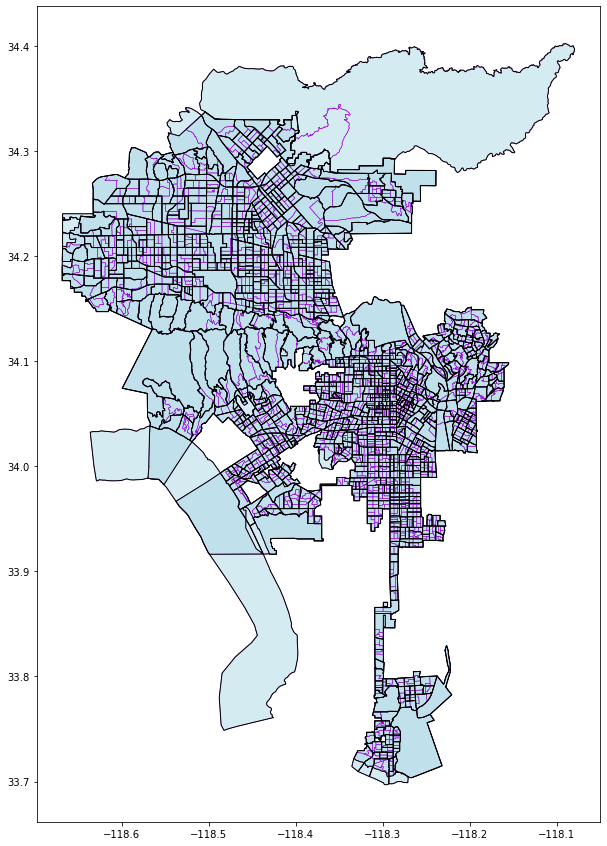

In [4]:
# compare
fig,ax = plt.subplots(figsize=(15,15))

# blue background of census tracts
gdf_tracts.plot(ax=ax,color="lightblue",zorder=10,alpha=0.5)

# black boundary of census tracts
gdf_tracts.boundary.plot(ax=ax,color='black',zorder=20,lw=1)

# while lines to show block groups (sandwiched between the two layers above for visual clarity)
gdf.boundary.plot(ax=ax,color='darkviolet',zorder=15,lw=0.5)

In [5]:
# total bounds
minx,miny,maxx,maxy = gdf.total_bounds

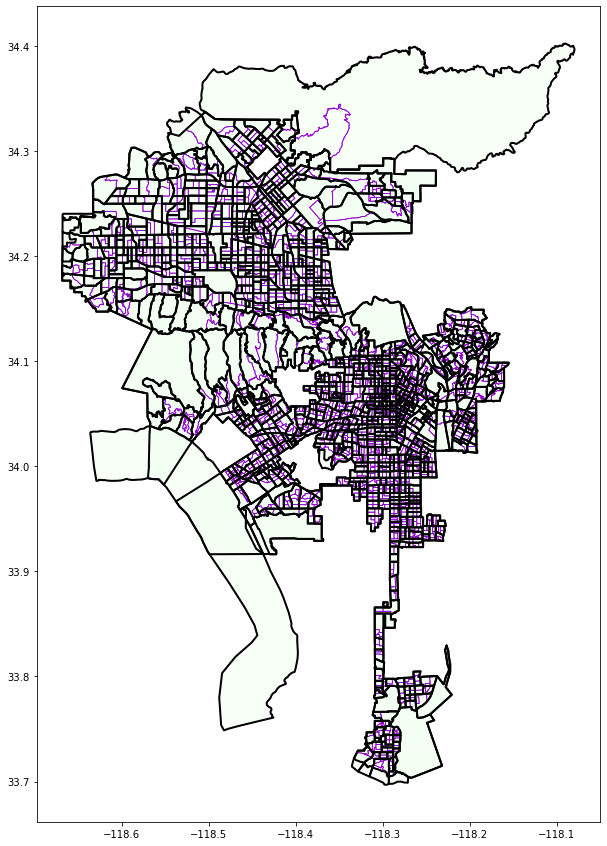

In [6]:
# compare
fig,ax = plt.subplots(figsize=(15,15))

# blue background of census tracts
gdf_tracts.plot(ax=ax,color='honeydew',zorder=10,alpha=0.5)

# black boundary of census tracts
gdf_tracts.boundary.plot(ax=ax,color='black',zorder=20,lw=2)

# while lines to show block groups (sandwiched between the two layers above for visual clarity)
gdf.boundary.plot(ax=ax,color='darkviolet',zorder=15,lw=0.8)

In [7]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   geoid             2516 non-null   object  
 1   name              2516 non-null   object  
 2   B01003001         2516 non-null   float64 
 3   B01003001, Error  2516 non-null   float64 
 4   geometry          2516 non-null   geometry
dtypes: float64(2), geometry(1), object(2)
memory usage: 98.4+ KB


In [8]:
# trim the data to the bare minimum columns
gdf = gdf[['geoid','B01003001','geometry']]

# rename the columns
gdf.columns = ['FIPS','TotalPop','geometry']

In [9]:
# last rows
gdf.tail()

FIPS   TotalPop  \
2511  15000US060379800261       37.0   
2512  15000US060379800281        0.0   
2513  15000US060379800311     1113.0   
2514  15000US060379902000        0.0   
2515       16000US0644000  3959657.0   

                                               geometry  
2511  MULTIPOLYGON (((-118.35173 34.28034, -118.3517...  
2512  MULTIPOLYGON (((-118.45246 33.94315, -118.4464...  
2513  MULTIPOLYGON (((-118.29105 33.75378, -118.2905...  
2514  MULTIPOLYGON (((-118.63598 34.03255, -118.6325...  
2515  MULTIPOLYGON (((-118.66818 34.18987, -118.6681...

In [10]:
# delete last row which is for the entire city of LA
gdf=gdf.drop(2515)

In [11]:
# fix FIPS code
gdf['FIPS'] = gdf['FIPS'].str.replace('15000US','')
gdf.tail()

FIPS  TotalPop  \
2510  060379800241     264.0   
2511  060379800261      37.0   
2512  060379800281       0.0   
2513  060379800311    1113.0   
2514  060379902000       0.0   

                                               geometry  
2510  MULTIPOLYGON (((-118.51849 34.18389, -118.5184...  
2511  MULTIPOLYGON (((-118.35173 34.28034, -118.3517...  
2512  MULTIPOLYGON (((-118.45246 33.94315, -118.4464...  
2513  MULTIPOLYGON (((-118.29105 33.75378, -118.2905...  
2514  MULTIPOLYGON (((-118.63598 34.03255, -118.6325...

In [13]:
# sort by total pop
gdf.sort_values(by='TotalPop').head(20)

FIPS  TotalPop  \
2514  060379902000       0.0   
2506  060379800201       0.0   
2358  060372772002       0.0   
2512  060379800281       0.0   
2509  060379800231       0.0   
2508  060379800221       0.0   
2501  060379800091       5.0   
2503  060379800141      10.0   
2507  060379800211      12.0   
2511  060379800261      37.0   
2500  060379800081      90.0   
2499  060379302002     118.0   
2505  060379800191     151.0   
2502  060379800101     189.0   
2510  060379800241     264.0   
2360  060372774002     294.0   
2498  060379302001     301.0   
2284  060372736003     310.0   
2092  060372640001     320.0   
1868  060372371013     321.0   

                                               geometry  
2514  MULTIPOLYGON (((-118.63598 34.03255, -118.6325...  
2506  MULTIPOLYGON (((-118.34412 34.21700, -118.3438...  
2358  MULTIPOLYGON (((-118.38597 33.94734, -118.3859...  
2512  MULTIPOLYGON (((-118.45246 33.94315, -118.4464...  
2509  MULTIPOLYGON (((-118.64870 34.23120, -118.6480...  
2508  MULTIPOLYGON (((-118.50266 34.30809, -118.5026...  
2501  MULTIPOLYGON (((-118.33707 34.14160, -118.3361...  
2503  MULTIPOLYGON (((-118.26088 33.76850, -118.2602...  
2507  MULTIPOLYGON (((-118.40183 34.26509, -118.4017...  
2511  MULTIPOLYGON (((-118.35173 34.28034, -118.3517...  
2500  MULTIPOLYGON (((-118.50267 34.22121, -118.5015...  
2499  MULTIPOLYGON (((-118.51028 34.34504, -118.5102...  
2505  MULTIPOLYGON (((-118.59919 34.07436, -118.5991...  
2502  MULTIPOLYGON (((-118.25165 34.08038, -118.2515...  
2510  MULTIPOLYGON (((-118.51849 34.18389, -118.5184...  
2360  MULTIPOLYGON (((-118.37868 33.95180, -118.3786...  
2498  MULTIPOLYGON (((-118.41035 34.29197, -118.4102...  
2284  MULTIPOLYGON (((-118.46583 33.99098, -118.4657...  
2092  MULTIPOLYGON (((-118.49381 34.05010, -118.4938...  
1868  MULTIPOLYGON (((-118.29148 33.98586, -118.2914...

In [14]:
# delete less than 100 population geographies
gdf = gdf[gdf['TotalPop']>100]

In [15]:
# get the layers into a web mercator projection
# reproject to web mercator
gdf = gdf.to_crs(epsg=3857)

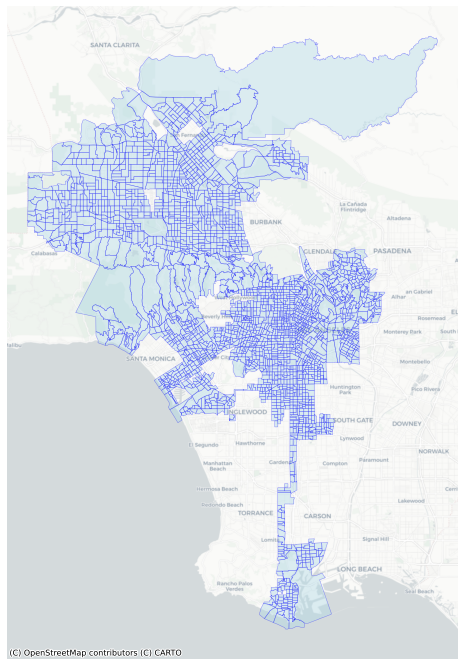

In [16]:
# plot it!
fig, ax = plt.subplots(figsize=(12,12))

gdf.plot(ax=ax,
         color='lightblue', 
         edgecolor='blue',
         lw=0.5,
         alpha=0.4)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [17]:
# Download LA median income income data. This data has a year, income and neighborhood columns, 
# as well as location column, which includes latitude and longitude. 
!wget -q -O 'la_median_income.csv' https://usc.data.socrata.com/api/views/ani7-k64m/rows.csv?accessType=DOWNLOAD
print('Income data downloaded!') 

# Download LA population data. This data has a year, population and neighborhood columns, 
# as well as location column, which includes latitude and longitude. 
!wget -q -O 'la_neighborhood_population.csv' https://usc.data.socrata.com/api/views/y65w-5vdw/rows.csv?accessType=DOWNLOAD
print('Population data downloaded!')

Income data downloaded!
Population data downloaded!


In [18]:
# This is the raw income dataframe 
la_raw_income_df = pd.read_csv('la_median_income.csv')
la_raw_income_df.head()

Policy_Area                  Dataset                 Variable  \
0  Employment & Income  Median Household Income  Median Household Income   
1  Employment & Income  Median Household Income  Median Household Income   
2  Employment & Income  Median Household Income  Median Household Income   
3  Employment & Income  Median Household Income  Median Household Income   
4  Employment & Income  Median Household Income  Median Household Income   

   Year      Count                 tract  tractnumber neighborhood  \
0  2010  59454.633  Census Tract 1011.10       101110      Tujunga   
1  2010  92667.531  Census Tract 1011.22       101122      Tujunga   
2  2010  45399.477  Census Tract 1012.10       101210      Tujunga   
3  2010  52599.750  Census Tract 1012.20       101220      Tujunga   
4  2010  69783.000     Census Tract 1013       101300      Tujunga   

                  GEOID                      location  \
0  1400000US06037101110  (34.25947853, -118.29299909)   
1  1400000US06037101122  (34.26772618, -118.29015869)   
2  1400000US06037101210  (34.25297726, -118.29074307)   
3  1400000US06037101220  (34.25161333, -118.28164445)   
4  1400000US06037101300  (34.24878243, -118.27101097)   

                                              Row_ID                    Date  \
0  Median_Household_Income_2010_1400000US06037101110  01/01/2010 12:00:00 AM   
1  Median_Household_Income_2010_1400000US06037101122  01/01/2010 12:00:00 AM   
2  Median_Household_Income_2010_1400000US06037101210  01/01/2010 12:00:00 AM   
3  Median_Household_Income_2010_1400000US06037101220  01/01/2010 12:00:00 AM   
4  Median_Household_Income_2010_1400000US06037101300  01/01/2010 12:00:00 AM   

   Denominator Denominator_Description  
0       1693.0        Total Households  
1       1304.0        Total Households  
2       2175.0        Total Households  
3       1173.0        Total Households  
4       1408.0        Total Households

In [19]:
# This is the raw population dataframe
la_raw_population_df = pd.read_csv('la_neighborhood_population.csv')
la_raw_population_df.head()

Policy Area           Dataset          Variable  Year   Count  \
0  Demography  Total Population  Total Population  2010  5017.0   
1  Demography  Total Population  Total Population  2010  3663.0   
2  Demography  Total Population  Total Population  2010  6799.0   
3  Demography  Total Population  Total Population  2010  3189.0   
4  Demography  Total Population  Total Population  2010  3808.0   

                  Tract  Tract Number Neighborhood                 GEOID  \
0  Census Tract 1011.10        101110      Tujunga  1400000US06037101110   
1  Census Tract 1011.22        101122      Tujunga  1400000US06037101122   
2  Census Tract 1012.10        101210      Tujunga  1400000US06037101210   
3  Census Tract 1012.20        101220      Tujunga  1400000US06037101220   
4     Census Tract 1013        101300      Tujunga  1400000US06037101300   

                       Location                                      Row ID  \
0  (34.25947853, -118.29299909)  Total_Population_2010_1400000US06037101110   
1  (34.26772618, -118.29015869)  Total_Population_2010_1400000US06037101122   
2  (34.25297726, -118.29074307)  Total_Population_2010_1400000US06037101210   
3  (34.25161333, -118.28164445)  Total_Population_2010_1400000US06037101220   
4  (34.24878243, -118.27101097)  Total_Population_2010_1400000US06037101300   

         Date  
0  01/01/2010  
1  01/01/2010  
2  01/01/2010  
3  01/01/2010  
4  01/01/2010

In [20]:

# Clean up the income data. 

# We can drop columns Policy_Area, Dataset, Variable, tract, tractnumber, GEOID, Row_ID, Date, 
# Denominator, Denominator_Description 
la_income_df = la_raw_income_df.drop(['Policy_Area', 'Dataset', 'Variable', 'tract', 'tractnumber', 'GEOID', 
                                      'location', 'Row_ID', 'Date', 'Denominator', 'Denominator_Description'], 
                                     axis=1)
la_income_df.rename(columns={'Count': 'Median Income', 'neighborhood':'Neighborhood'}, inplace=True)
la_income_df.head()

Year  Median Income Neighborhood
0  2010      59454.633      Tujunga
1  2010      92667.531      Tujunga
2  2010      45399.477      Tujunga
3  2010      52599.750      Tujunga
4  2010      69783.000      Tujunga

In [21]:
# Clean up the population data. 

# We can drop columns Policy_Area, Dataset, Variable, tract, tractnumber, GEOID, Row_ID, Date, 
# Denominator, Denominator_Description 
la_population_df = la_raw_population_df.drop(['Policy Area', 'Dataset', 'Variable', 'Tract', 'Tract Number', 'GEOID', 
                                      'Location', 'Row ID', 'Date'], 
                                     axis=1)
la_population_df.rename(columns={'Count': 'Population', 'neighborhood':'Neighborhood'}, inplace=True)
la_population_df.head()

Year  Population Neighborhood
0  2010      5017.0      Tujunga
1  2010      3663.0      Tujunga
2  2010      6799.0      Tujunga
3  2010      3189.0      Tujunga
4  2010      3808.0      Tujunga

In [22]:
la_population_df.tail()

Year  Population Neighborhood
23433  2019      6550.0     Winnetka
23434  2019      4516.0     Glendale
23435  2019      3910.0  Temple City
23436  2019      4577.0   Long Beach
23437  2019      3312.0    San Pedro

In [23]:
la_2018_income_df = la_income_df.loc[la_income_df['Year'] == 2018]
la_2018_income_df.drop(['Year'], axis=1, inplace=True)
la_2018_income_df.reset_index(drop=True, inplace=True) # Resets index and drops old index values
la_2018_income_df.shape

/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(2344, 2)

In [24]:
# Drop rows with missing income data
la_2018_income_df.dropna(inplace=True)
la_2018_income_df.reset_index(drop=True, inplace=True)
la_2018_income_df.shape

<ipython-input-24-c2ede478e7fb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  la_2018_income_df.dropna(inplace=True)


(2308, 2)

In [25]:
# Extract all 2018 population data
la_2018_population_df = la_population_df.loc[la_population_df['Year'] == 2018]
la_2018_population_df.drop(['Year'], axis=1, inplace=True)
la_2018_population_df.reset_index(drop=True, inplace=True) # Resets index and drops old index values
la_2018_population_df.shape

(2344, 2)

In [26]:
# Drop rows with missing population data
la_2018_population_df.dropna(inplace=True)
la_2018_population_df.reset_index(drop=True, inplace=True)
la_2018_population_df.shape

<ipython-input-26-175252b96e59>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  la_2018_population_df.dropna(inplace=True)


(2322, 2)

In [27]:
# Sort in neighborhood order
la_2018_income_df.sort_values(by=['Neighborhood'], inplace=True)
la_2018_income_df.reset_index(drop=True, inplace=True)
la_2018_income_df.head()

<ipython-input-27-104184293d0d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  la_2018_income_df.sort_values(by=['Neighborhood'], inplace=True)


Median Income     Neighborhood
0        94137.0            Acton
1       111618.0            Acton
2        36852.0  Adams-Normandie
3        46429.0  Adams-Normandie
4        20685.0  Adams-Normandie

In [28]:
# Sort in neighborhood order
la_2018_population_df.sort_values(by=['Neighborhood'], inplace=True)
la_2018_population_df.reset_index(drop=True, inplace=True)
la_2018_population_df.head()

<ipython-input-28-061d8dcdf81e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  la_2018_population_df.sort_values(by=['Neighborhood'], inplace=True)


Population     Neighborhood
0      4687.0            Acton
1      2926.0            Acton
2      2811.0  Adams-Normandie
3      3130.0  Adams-Normandie
4      4194.0  Adams-Normandie

In [29]:
# There are several entries per neighborhood. To keep data simple, find the mean for each of the 
# neighborhoods. Drop the location column because we now want to keep one central location per
# neighborhood. We can find the latitude, longitude for each neighborhood using geolocator
la_2018_income_df = la_2018_income_df.groupby(['Neighborhood']).mean()
la_2018_income_df = la_2018_income_df.round(2)
la_2018_income_df = la_2018_income_df.reset_index(drop=False)
la_2018_income_df.head()
la_2018_income_df['Latitude'] = ""
la_2018_income_df['Longitude'] = ""
la_2018_income_df.head()

Neighborhood  Median Income Latitude Longitude
0            Acton      102877.50                   
1  Adams-Normandie       34859.60                   
2     Agoura Hills      130459.67                   
3       Agua Dulce       84048.00                   
4         Alhambra       59975.25

In [30]:

# There are several entries per neighborhood. To keep data simple, find the total for each of the 
# neighborhoods. Drop the location column because it's coming from the income dataframe that we will
# merge with the population dataframe later on
la_2018_population_df = la_2018_population_df.groupby(['Neighborhood']).sum()
la_2018_population_df = la_2018_population_df.reset_index(drop=False)
la_2018_population_df['Population'] = la_2018_population_df['Population'].astype(int)
la_2018_population_df.head()

Neighborhood  Population
0            Acton        7613
1  Adams-Normandie       18237
2     Agoura Hills       18943
3       Agua Dulce        4074
4         Alhambra       84974

In [31]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import numpy as np # library to handle data in a vectorized manner

In [32]:
# Find latitude and longitude for each neighborhood using geolocator. For those that are not
# avaialable, assign NaN for now. Note that we are looking for the location of all the neighborhoods in LA, even
# though we will later analyze only the lowest and the highest income ones. This is because we want to visualize
# where the neighborhoods are with the lowest and highest income, along with the rest of the neighborhoods.
for neighborhood in la_2018_income_df['Neighborhood']:
    address = (neighborhood+','+ 'Los Angeles')
    geolocator = Nominatim(user_agent="la_explorer")
    location = geolocator.geocode(address)
    try:
        latitude = location.latitude
        longitude = location.longitude
    except:
        latitude = np.NaN
        longitude = np.NaN
    la_2018_income_df.loc[la_2018_income_df['Neighborhood'] == neighborhood, "Latitude"] = latitude
    la_2018_income_df.loc[la_2018_income_df['Neighborhood'] == neighborhood, "Longitude"] = longitude

In [33]:

# Now the income dataframe has latitude and longitude information for each neighborhood
la_2018_income_df.head()

Neighborhood  Median Income Latitude Longitude
0            Acton      102877.50  34.4807  -118.187
1  Adams-Normandie       34859.60  34.0318    -118.3
2     Agoura Hills      130459.67  34.1479  -118.766
3       Agua Dulce       84048.00  34.4964  -118.326
4         Alhambra       59975.25   34.093  -118.127

In [34]:

# See how many neighborhoods returned NaN location information
la_2018_income_df.isnull().sum(axis = 0)

Neighborhood     0
Median Income    0
Latitude         8
Longitude        8
dtype: int64

In [35]:
# Which neighborhoods returned NaN location
is_NaN = la_2018_income_df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = la_2018_income_df[row_has_NaN]
rows_with_NaN

Neighborhood  Median Income Latitude Longitude
37                         Castaic Canyons       97670.83      NaN       NaN
147              Northeast Antelope Valley       43513.60      NaN       NaN
149              Northwest Antelope Valley       73508.25      NaN       NaN
202              Southeast Antelope Valley       63291.67      NaN       NaN
214                        Tujunga Canyons       88345.50      NaN       NaN
215  Unincorporated Santa Monica Mountains      134605.14      NaN       NaN
216  Unincorporated Santa Susana Mountains      108205.75      NaN       NaN
241               West Whittier-Los Nietos       71138.20      NaN       NaN

In [36]:
# Drop NaN location neighborhoods
la_2018_income_df = la_2018_income_df.dropna()
la_2018_income_df.shape

(246, 4)

In [37]:
la_2018_income_df.head()

Neighborhood  Median Income Latitude Longitude
0            Acton      102877.50  34.4807  -118.187
1  Adams-Normandie       34859.60  34.0318    -118.3
2     Agoura Hills      130459.67  34.1479  -118.766
3       Agua Dulce       84048.00  34.4964  -118.326
4         Alhambra       59975.25   34.093  -118.127

In [38]:
# Now that our income data is clean, we want to merge this dataframe with the population
# dataframe so that we get a single dataframe that has neighborhood, income, population,
# latitude and longitude information
la_2018_merged_df = la_2018_income_df.merge(la_2018_population_df, left_on='Neighborhood', 
                                            right_on='Neighborhood', how='inner')
la_2018_merged_df = la_2018_merged_df[['Neighborhood','Population','Median Income','Latitude',
                                       'Longitude']]
la_2018_merged_df.head()

Neighborhood  Population  Median Income Latitude Longitude
0            Acton        7613      102877.50  34.4807  -118.187
1  Adams-Normandie       18237       34859.60  34.0318    -118.3
2     Agoura Hills       18943      130459.67  34.1479  -118.766
3       Agua Dulce        4074       84048.00  34.4964  -118.326
4         Alhambra       84974       59975.25   34.093  -118.127

In [39]:
la_2018_lowest_income_df = la_2018_merged_df.sort_values(by=['Median Income']).head(20)
la_2018_lowest_income_df = la_2018_lowest_income_df.reset_index(drop=True)
la_2018_lowest_income_df

Neighborhood  Population  Median Income Latitude Longitude
0          University Park       25307       18902.00  34.0274  -118.284
1                    Watts       45364       31559.11  33.9406  -118.243
2         Lake Los Angeles        5684       32500.00  34.6125  -117.828
3               Pico-Union       42250       33050.08  34.0466  -118.288
4               South Park       38810       34388.12  33.9959   -118.27
5          Adams-Normandie       18237       34859.60  34.0318    -118.3
6      Broadway-Manchester       24827       35016.20   33.941  -118.274
7   Historic South-Central       44932       35073.64  34.0162  -118.267
8           Vermont Knolls       25767       35244.50  33.9668  -118.292
9                 Westlake      112237       35582.20  34.0629  -118.273
10                Westmont       33723       35625.43  33.9414  -118.302
11         Vermont-Slauson       34975       36002.88  33.9837  -118.292
12         Exposition Park       34253       36646.86  34.0137  -118.287
13                Florence       53591       37205.23  33.9742  -118.243
14           Vermont Vista       26920       37277.17  33.9419  -118.286
15     Chesterfield Square       14680       37502.67  33.9835  -118.314
16         Central-Alameda       45709       37793.90   34.004  -118.248
17          Vermont Square       46335       38734.00  34.0019    -118.3
18         Harvard Heights       20576       38880.50  34.0471  -118.305
19         Lincoln Heights       24852       38896.83  34.0709   -118.21

In [40]:

# Get a list of 20 neighborhoods with the highest Median Income. 
la_2018_highest_income_df = la_2018_merged_df.sort_values(by=['Median Income'], ascending=False).head(20)
la_2018_highest_income_df = la_2018_highest_income_df.reset_index(drop=True)
la_2018_highest_income_df

Neighborhood  Population  Median Income Latitude Longitude
0           Rolling Hills        1630      239375.00  33.7668   -118.35
1           Beverly Crest       11591      194479.33  34.1168  -118.432
2       Pacific Palisades       24281      193741.43  34.0481  -118.526
3                 Bel-Air        7623      193646.00  34.0827  -118.448
4    Palos Verdes Estates       13523      183358.33  33.7872  -118.402
5    La Canada Flintridge       19686      176186.25  34.1998  -118.201
6             Beverlywood        3929      168224.00  34.0459  -118.395
7               Brentwood       33846      164631.20  34.0521  -118.474
8   Rolling Hills Estates        8232      162792.00  33.7878  -118.358
9                  Malibu       10385      161419.50  34.0356  -118.689
10        Manhattan Beach       35573      159236.50  33.8916  -118.395
11             San Marino       13285      158421.00  34.1216  -118.106
12        Stevenson Ranch        5979      151827.00  34.3882  -118.585
13          Cheviot Hills        9094      143369.50  34.0406   -118.41
14          Hermosa Beach       19650      135662.00  33.8643  -118.396
15   Hollywood Hills West       13500      134772.00  34.1105  -118.373
16    Rancho Palos Verdes       44986      134225.44  33.7483  -118.371
17           Hidden Hills        5568      133971.00  34.1641  -118.658
18           Porter Ranch       27205      131127.86  34.2818  -118.561
19           Agoura Hills       18943      130459.67  34.1479  -118.766

In [41]:

# Get geolocator information
address = 'Los Angeles, CA'
geolocator = Nominatim(user_agent="la_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [42]:
# Visualize Los Angeles neighborhoods
map_la = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lng, neighborhood, income in zip(la_2018_income_df['Latitude'], 
                                          la_2018_income_df['Longitude'], 
                                          la_2018_income_df['Neighborhood'],
                                         la_2018_income_df['Median Income']):
    popup_string = '{}, ${}'.format(neighborhood, str(income))
    label = folium.Popup(popup_string, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        line_opacity=0.2,
        parse_html=False).add_to(map_la)

for lat, lng, neighborhood, income in zip(la_2018_lowest_income_df['Latitude'], 
                                          la_2018_lowest_income_df['Longitude'], 
                                          la_2018_lowest_income_df['Neighborhood'],
                                         la_2018_lowest_income_df['Median Income']):
    popup_string = '{}, ${}'.format(neighborhood, str(income))
    label = folium.Popup(popup_string, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        line_opacity=0.2,
        parse_html=False).add_to(map_la)

for lat, lng, neighborhood, income in zip(la_2018_highest_income_df['Latitude'], 
                                          la_2018_highest_income_df['Longitude'], 
                                          la_2018_highest_income_df['Neighborhood'],
                                         la_2018_highest_income_df['Median Income']):
    popup_string = '{}, ${}'.format(neighborhood, str(income))
    label = folium.Popup(popup_string, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        line_opacity=0.2,
        parse_html=False).add_to(map_la)    
    
map_la

In [43]:
# Visualize Los Angeles neighborhoods
map2_la = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lng, neighborhood, income in zip(la_2018_income_df['Latitude'], 
                                          la_2018_income_df['Longitude'], 
                                          la_2018_income_df['Neighborhood'],
                                         la_2018_income_df['Median Income']):
    popup_string = '{}, ${}'.format(neighborhood, str(income))
    label = folium.Popup(popup_string, parse_html=True)
    folium.Choropleth()
    geo_data=la_explorer
    [lat,lng],
    data=la_2018_income_df,
    columns=["Neighborhood", "Median Income"],
    key_on="feature.id",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Median Income",

folium.LayerControl().add_to(map2_la)

map2_la



TypeError: __init__() missing 1 required positional argument: 'geo_data'

In [ ]:
# Overlaying with SPA lines
gdf_spa = gpd.read_file('data/LA_County_Service_Planning_Area.shp')
print (gdf_spa)

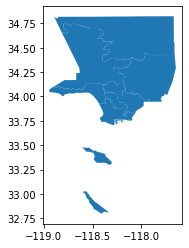

In [49]:
%matplotlib inline
gdf_spa.plot()

In [50]:
# connect to the data portal
client = Socrata("data.lacity.org", None)

results = client.get("amvf-fr72", 
                     limit=50000,
                     where = "arst_date between '2020-07-01T00:00:00' and '2021-01-31T00:00:00'",
                     order='arst_date desc')

# Convert to pandas DataFrame
arrests = pd.DataFrame.from_records(results)

In [51]:
arrests.shape

(35313, 25)

In [52]:
# convert pandas dataframe to geodataframe
arrests = gpd.GeoDataFrame(arrests, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(arrests.lon, arrests.lat))

In [53]:
# get the layers into a web mercator projection
# reproject to web mercator
arrests = arrests.to_crs(epsg=3857)

In [54]:
# convert lat/lon to floats
arrests.lon = arrests.lon.astype('float')
arrests.lat = arrests.lat.astype('float')

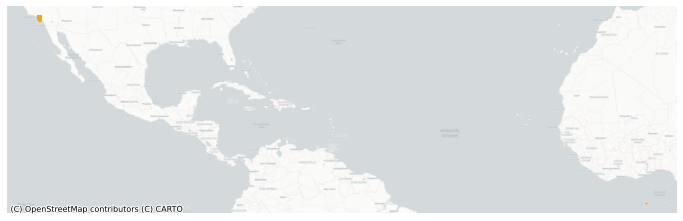

In [55]:
# map it!
fig,ax = plt.subplots(figsize=(12,12))

arrests.plot(ax=ax,
             color='orange',
             markersize=1)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)


In [56]:
# subset the zero coordinate records
arrests[arrests.lon==0]

rpt_id report_type                arst_date  time area   area_desc  \
11598  6051801     BOOKING  2020-11-14T00:00:00.000  0326   17  Devonshire   

         rd age sex_cd descent_cd  ... location  \
11598  1706  30      M          B  ...  RINALDI   

                                 crsst  lat  lon  \
11598  405                          FY  0.0  0.0   

                                     location_1                 bkg_date  \
11598  {'type': 'Point', 'coordinates': [0, 0]}  2020-11-14T00:00:00.000   

      bkg_time       bgk_location  bkg_loc_cd                 geometry  
11598     0510  VALLEY - JAIL DIV        4279  POINT (0.00000 0.00000)  

[1 rows x 26 columns]

In [57]:
# drop the unmapped rows
arrests = arrests[arrests.lon!=0]

In [67]:
#drop the arrests that are under the age of 19
arrests['age'] = arrests['age'].astype(int)
arrests_adult = arrests[arrests.age>=19]

In [69]:
print (arrests_adult)

          rpt_id report_type                arst_date  time area    area_desc  \
0        6116744     BOOKING  2021-01-31T00:00:00.000  2340   12  77th Street   
1        6116365     BOOKING  2021-01-31T00:00:00.000  0030   13       Newton   
2        6116436     BOOKING  2021-01-31T00:00:00.000  1140   01      Central   
3        6116485     BOOKING  2021-01-31T00:00:00.000  1430   15  N Hollywood   
4        6116759     BOOKING  2021-01-31T00:00:00.000  2345   16     Foothill   
...          ...         ...                      ...   ...  ...          ...   
35306    5964326     BOOKING  2020-07-01T00:00:00.000  2045   12  77th Street   
35307    5963979     BOOKING  2020-07-01T00:00:00.000  0850   14      Pacific   
35308    5964184     BOOKING  2020-07-01T00:00:00.000  1615   12  77th Street   
35309    5963849     BOOKING  2020-07-01T00:00:00.000  0001   02      Rampart   
35311  201711202         RFC  2020-07-01T00:00:00.000  1840   17   Devonshire   

         rd  age sex_cd des

In [70]:
arrests_youth = arrests[arrests.age<=19]

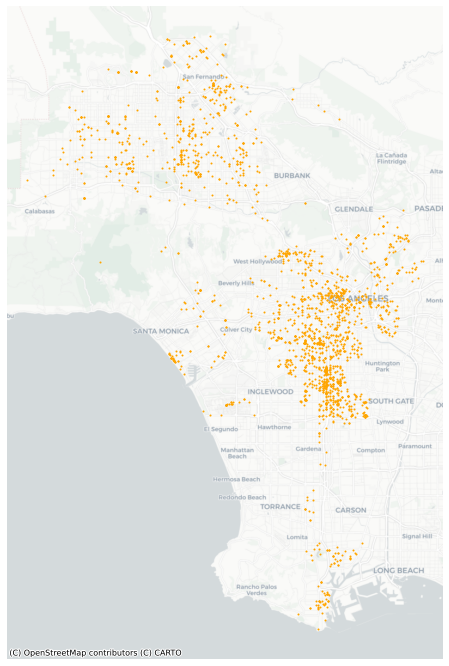

In [71]:
# map it!
fig,ax = plt.subplots(figsize=(12,12))

arrests_youth.plot(ax=ax,
             color='orange',
             markersize=1)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)


In [72]:
fig = px.scatter_mapbox(arrests_youth,
                        lat="lat", 
                        lon="lon", 
                        color="age",
                        color_continuous_scale=px.colors.sequential.Viridis_r,
                        labels={'age':'Age'}
                       )

fig.update_layout(mapbox_style="open-street-map")

fig.show()

In [74]:
# get the bounding box coordinates for the arrest data
minx, miny, maxx, maxy = arrests_youth.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-13209215.30532616
-13153600.087725839
3989526.8110836204
4072862.506125747


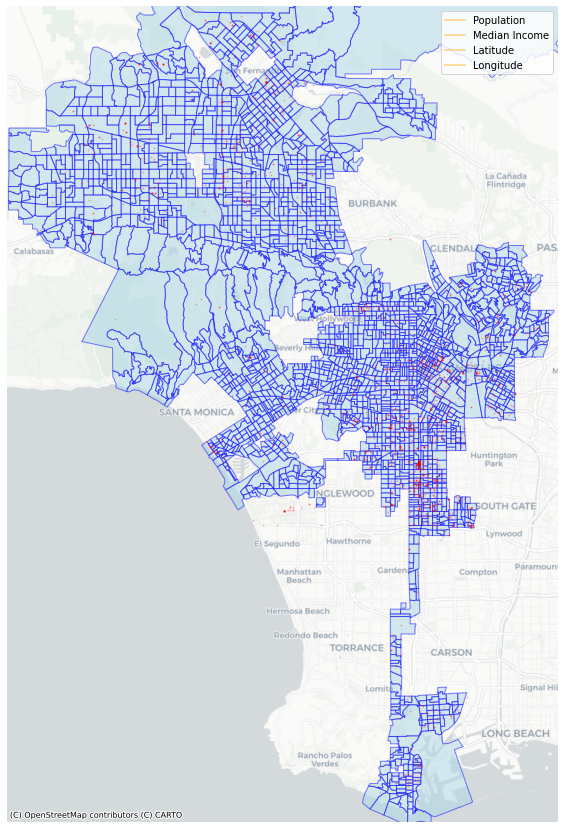

In [83]:
# set up the plot canvas with plt.subplots
fig, ax = plt.subplots(figsize=(15, 15))

# block groups
gdf.plot(ax=ax, # this puts it in the ax plot
        color='lightblue', 
        edgecolor='blue',
        alpha=0.5)

#lowest_income
la_2018_lowest_income_df.plot(ax=ax,
                      color='orange',
                      markersize=4,
                      alpha=0.5)

# arrests
arrests_youth.plot(ax=ax, # this also puts it in the same ax plot
            color='red',
            markersize=1,
            alpha=0.2)

# use the bounding box coordinates to set the x and y limits
ax.set_xlim(minx - 1000, maxx + 1000) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 1000, maxy + 1000)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

AttributeError: 'PatchCollection' object has no property 'ax2'

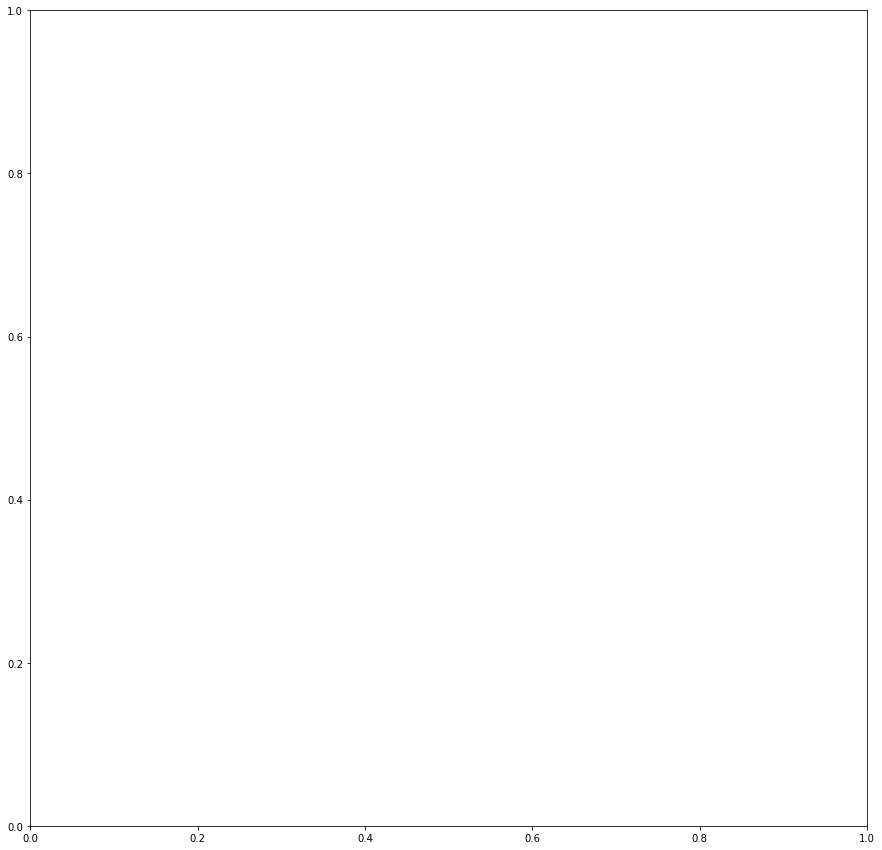

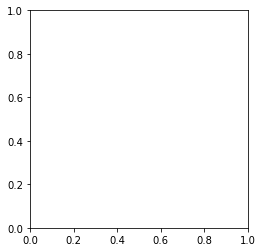

In [88]:
#spa
# set up the plot canvas with plt.subplots
fig, ax2 = plt.subplots(figsize=(15, 15))
gdf_spa.plot(ax2=ax2, #placing it on the same ax plot 
        color='none',
        linewidths='black',
        edgecolor='black',
        alpha=0.8)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [90]:
# Do the spatial join
join = gpd.sjoin(arrests_youth, gdf, how='left')
join.head()

rpt_id report_type                arst_date  time area  area_desc  \
21    6116373     BOOKING  2021-01-31T00:00:00.000  0740   18  Southeast   
32  211805544         RFC  2021-01-31T00:00:00.000  1345   18  Southeast   
42    5937096     BOOKING  2021-01-31T00:00:00.000  0100   20    Olympic   
45    5937094     BOOKING  2021-01-31T00:00:00.000  0215   20    Olympic   
55    6116598     BOOKING  2021-01-31T00:00:00.000  1825   03  Southwest   

      rd  age sex_cd descent_cd  ...       lon  \
21  1841   18      M          H  ... -118.2826   
32  1822   19      F          B  ... -118.2826   
42  2017    8      F          H  ... -118.2954   
45  2017   11      M          H  ... -118.2954   
55  0398   18      M          H  ... -118.2850   

                                           location_1  \
21  {'type': 'Point', 'coordinates': [-118.2826, 3...   
32  {'type': 'Point', 'coordinates': [-118.2826, 3...   
42  {'type': 'Point', 'coordinates': [-118.2954, 3...   
45  {'type': 'Point', 'coordinates': [-118.2954, 3...   
55  {'type': 'Point', 'coordinates': [-118.285, 34...   

                   bkg_date bkg_time           bgk_location bkg_loc_cd  \
21  2021-01-31T00:00:00.000     1101  METRO - JAIL DIVISION       4273   
32                      NaN      NaN                    NaN        NaN   
42  2021-01-31T00:00:00.000     0813              HOLLYWOOD       4206   
45  2021-01-31T00:00:00.000     0819              HOLLYWOOD       4206   
55  2021-01-31T00:00:00.000     2056                77TH ST       4212   

                             geometry index_right          FIPS  TotalPop  
21  POINT (-13167158.802 4019540.771)      2024.0  060372412022    1159.0  
32  POINT (-13167158.802 4021124.047)      1985.0  060372404022    1363.0  
42  POINT (-13168583.691 4038138.000)      1385.0  060372113202    1993.0  
45  POINT (-13168583.691 4038138.000)      1385.0  060372113202    1993.0  
55  POINT (-13167425.968 4029795.709)      1767.0  060372317201    2846.0  

[5 rows x 29 columns]

In [91]:
arrests_by_gdf = join.FIPS.value_counts().rename_axis('FIPS').reset_index(name='arrests_count')

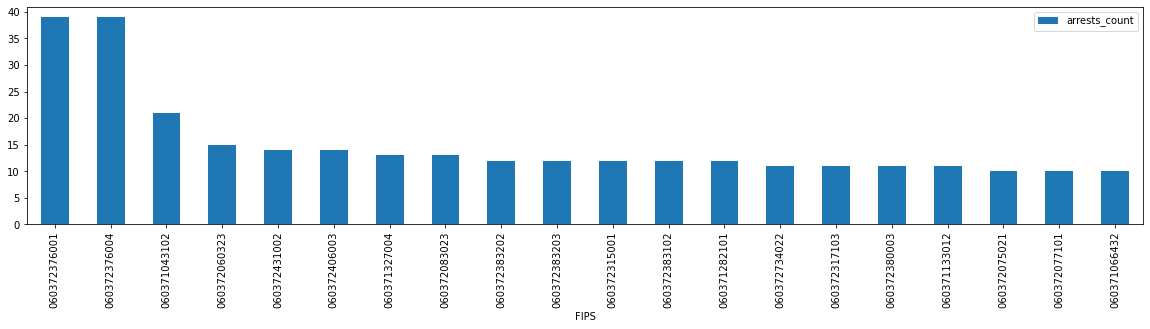

In [92]:
# make a bar chart of top 20 geographies
arrests_by_gdf[:20].plot.bar(figsize=(20,4),
                             x='FIPS',
                             y='arrests_count')

In [94]:
gdf=gdf.merge(arrests_by_gdf,on='FIPS')

In [95]:
gdf.head()

FIPS  TotalPop                                           geometry  \
0  060371011102    1529.0  MULTIPOLYGON (((-13169350.794 4063591.834, -13...   
1  060371012202    2484.0  MULTIPOLYGON (((-13167528.939 4062726.771, -13...   
2  060371013001    1338.0  MULTIPOLYGON (((-13166665.322 4063197.342, -13...   
3  060371032002    1980.0  MULTIPOLYGON (((-13177225.869 4065687.086, -13...   
4  060371041052    3921.0  MULTIPOLYGON (((-13181378.865 4065742.722, -13...   

   arrests_count  
0              1  
1              1  
2              1  
3              2  
4              5

In [96]:
gdf['arrests_per_1000'] = gdf['arrests_count']/gdf['TotalPop']*1000

In [97]:
gdf.sort_values(by="arrests_per_1000").tail()

FIPS  TotalPop  \
710  060372383202     960.0   
604  060372317101     601.0   
48   060371066432     714.0   
686  060372376001    1211.0   
689  060372376004     969.0   

                                              geometry  arrests_count  \
710  MULTIPOLYGON (((-13167656.734 4023858.534, -13...             12   
604  MULTIPOLYGON (((-13168153.998 4029783.488, -13...              8   
48   MULTIPOLYGON (((-13194656.497 4068199.609, -13...             10   
686  MULTIPOLYGON (((-13167654.841 4026132.403, -13...             39   
689  MULTIPOLYGON (((-13167410.829 4025590.204, -13...             39   

     arrests_per_1000  
710         12.500000  
604         13.311148  
48          14.005602  
686         32.204789  
689         40.247678

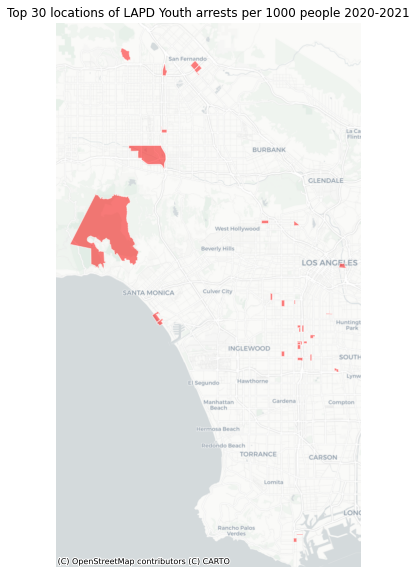

In [108]:
# map the top 20 geographies
fig,ax = plt.subplots(figsize=(12,10))
gdf.sort_values(by='arrests_per_1000',ascending=False)[:30].plot(ax=ax,
                                                                 color='red',
                                                                 edgecolor='white',
                                                                 alpha=0.5,legend=True)

# title
ax.set_title('Top 30 locations of LAPD Youth arrests per 1000 people 2020-2021')

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [109]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(gdf,k=8)

# Row-standardization
wq.transform = 'r'